In [30]:
from ipywidgets.widgets import HBox,VBox, Layout, Output, Button, Label, Text, RadioButtons, IntProgress
from IPython.display import Javascript, display, FileLink, HTML
from ipywidgets import widgets, link

from metadata.widgets import upload_file_button

import os
import glob as glob
import plotly.graph_objects as go


try:
    custom_widgets
    importlib.reload(custom_widgets)
except NameError:
    import custom_widgets

#####################################
######       Appearance        ######
#####################################

title='Hygrometer Plot Dashboard'
 
description='This tool is a dashboard to view hygrometer data throughout MatSci.'
 
# Add more than 1 author to the list using the name-email key-value pair
authors=[{'name':'Kevin DeBoyace', 'email': 'kevin.deboyace@pfizer.com'}]
 
# Add more instructions by adding to the list
instructions=['text1',
              'text2'
             ]

hdr = custom_widgets.header(title=title,
                      description=description,
                      authors=authors,
                      instructions=instructions)



display(hdr) # display header



box_layout = Layout(display = 'flex',
                    flex_flow = 'row',
                    align_items = 'center',
                    #border = '0.5px solid black',
                    width = '40%',
                    justify_content='center'
                   )

#####################################
#####     Import file button    #####
#####################################
box_file, upload_file = upload_file_button()

upload_bx = HBox([upload_file], layout = box_layout)
#display(upload_bx)


# Run button
def run_all(ev): # function to run all jupyter cells below this one
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

def run_next(ev): # function to run specific jupyter cell
    display(Javascript("Jupyter.notebook.execute_cells([2])"))

exec_button = Button(description="Run")
exec_button.style.button_color='MediumSeaGreen'
exec_button.on_click(run_all)




#####################################
#####      Display Buttons      #####
##################################### 
# Display upload button
upload_box = HBox([upload_file], layout = box_layout)
display(upload_box)
# Display execute button
#run_bx = HBox([exec_button], layout = box_layout)
#display(run_bx)
# display delete buttons
#horz_box = HBox([del_csv_button, del_ris_button], layout = box_layout)
horz_box = HBox([exec_button], layout = box_layout)
display(horz_box)


# observe status (upload)
def on_change_uploadfile(c): # currently unused
    print(c.new)
       

HTML(value='<style>\n    #custom-header div {\n        margin-bottom: 10px;\n    }\n    #authors ul {\n       …

In [31]:
#from metadata import hygrometer_plots

<div class="alert alert-block alert-info" style="text-align: right">
<b>Version 1.0.0 </b> 
</div>

In [32]:
#%%
# Hygrometer_plots

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import glob as glob
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#####################################
#####      Import CSV files      #####
##################################### 
def get_csv():
    f1 = glob.glob('*.csv')
    f2 = glob.glob('*.CSV')
    file_names = f1+f2
    return file_names


file_names = get_csv() # Get csv files



#####################################
#####         Plotting          #####
#####################################
cmap = plt.cm.get_cmap('tab10') # get colormap

# plot hygrometer data 
def plot_hygrom(df):
    # Internal channel
    fig, ax1 = plt.subplots()
    ax1.plot(df.datetime, df.temp1, color=cmap(0), linewidth=0.7)
    ax1.set_xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    ax1.set_ylabel('Int Temperature (C)', color=cmap(0))
    
    ax2=ax1.twinx()
    ax2.plot(df.datetime, df.rh1, color=cmap(1), linewidth=0.7)
    ax2.set_ylabel('Int Relative Humidity (%)', color=cmap(1))
    plt.xticks(rotation=45, ha='right')
    
    # External channel
    fig, ax3 = plt.subplots()
    ax3.plot(df.datetime, df.temp2, color=cmap(2), linewidth=0.7)
    plt.xticks(rotation=45, ha='right') # keep early or this doesn't work
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Ext Temperature (C)', color=cmap(2))

    ax4=ax3.twinx()
    ax4.plot(df.datetime, df.rh2, color=cmap(4), linewidth=0.7)
    ax4.xaxis.set_tick_params(rotation=45)
    ax4.set_ylabel('Ext Relative Humidity (%)', color=cmap(4))
    #plt.xticks(rotation=45, ha='right') # NOT WORKING?
    plt.show()

    
    

  
#fig = go.FigureWidget()


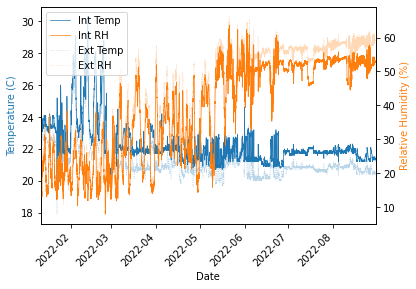

In [74]:

# USE FILENAME to add on to single dataframe rather than make higher dimensional df? 



# Add smoothing option? 



i = 1

#for i in range (0, len(file_names)):
df = (pd.read_csv(file_names[i], skiprows=7, sep='\s*,', engine = 'python', skipinitialspace=True, skipfooter=1, names=['rh1','temp1','rh2','temp2','time','date']))
#leading spaces after first row of data cause import issues. Skipping header + initial row of data appears to have fixed this issue. 
# final row is just four spaces/ indent --> deleted with skipfooter=1
#df.info()

# First RH imported with '+' - need to remove
df = df.replace({'\x00':'','\+':'','----':'0'},regex=True) # delete leading null and + and ---- from text file

 # convert to float
df.rh1 = pd.to_numeric(df.rh1)
df.rh2 = pd.to_numeric(df.rh2) 
df.temp1 = pd.to_numeric(df.temp1)
df.temp2 = pd.to_numeric(df.temp2)

# Create new dataframe column with datetime format
df.loc[:,'datetime']= np.transpose([df.date + ' '+ df.time]) # combine date and time
df.datetime = pd.to_datetime(df.datetime) # convert to datetime format (NOTE: seems slow)

# delete 2012 data 
# hygrometer defaults to year 2012 before date is set, removing this data since it is not useful
datecut = datetime.datetime.strptime('01-01-2013 00:00:00','%m-%d-%Y %H:%M:%S')
df = df.drop(df[df.datetime < datecut].index) # drop data where dates are in 2012



# plot hygrometer data all on 1 plot - For some reason this needs to be after df is created (+ df.datetime)
def plot_hygrom_combo(df, left=min(df.datetime), right=max(df.datetime)):
    fig, ax1 = plt.subplots()
    int_temp = ax1.plot(df.datetime, df.temp1, color=cmap(0), linewidth=0.7, label='Int Temp') # Internal
    ext_temp = ax1.plot(df.datetime, df.temp2, color=cmap(0), linewidth=0.7, alpha=0.3, linestyle=':', label='Ext Temp') # External
    plt.xticks(rotation=45, ha='right')
    
    #axes
    ax2=ax1.twinx()
    int_rh = ax2.plot(df.datetime, df.rh1, color=cmap(1), linewidth=0.7, label='Int RH') # Internal
    ext_rh = ax2.plot(df.datetime, df.rh2, color=cmap(1), linewidth=0.7, alpha=0.3, linestyle=':', label='Ext RH') # External
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (C)', color=cmap(0))
    ax2.set_ylabel('Relative Humidity (%)', color=cmap(1))
    
    #Legend
    lgs = int_temp+int_rh+ext_temp+ext_rh
    labs = [l.get_label() for l in lgs]
    plt.legend(lgs, labs, loc='upper left')
    
    #print(ax1.get_xlim())
    #plt.xlim(datetime(min_x),datetime(max_x))
    plt.xlim(left, right)
    plt.ylim
    
    plt.show()
    return fig
    

#plot_hygrom(df)
fig = plot_hygrom_combo(df)
#fig = plot_hygrom_combo(df, left='2022-04-01', right='2022-04-30')


In [82]:



#############
## WIDGETS ##
#############

#dates = [datetime.date(2015,i,1) for i in range(1,13)]
#options = [(i.strftime('%b'), i) for i in dates]
#widgets.SelectionRangeSlider(
#    options=options,
#    index=(0,11),
#    description='Months (2015)',
#    disabled=False
#)

# ------------
# Date Picker'
# ------------
# pre-set min and max dates
#left = min(df.datetime).date()
#right = max(df.datetime).date()
# adding .date() converts from pandas date to python date format. Was getting error about comparing the two being deprecated. 

left_update, right_update = widgets.DatePicker(description='Start Date', value = min(df.datetime).date(), disabled=False),\
    widgets.DatePicker(description='End Date', value = max(df.datetime).date(), disabled=False)

#l = widgets.jslink((left_update, 'value'), (right_update, 'value')) # link widgets



def on_value_change_left(change):#, left, right):
    #fig = plot_hygrom_combo(df,left_update.value,right_update.value)
    #fig.clear()
    plot_update(df, left_update.value, right_update.value)
    #fig = plot_update(fig, df, left_update.value, right_update.value)

    #return fig
    
left_update.observe(on_value_change_left, names='value')

def on_value_change_right(change):#, left= min(df.datetime), right= max(df.datetime)):
    #print(change['new'])
    #right = change['new']
    #fig.clear()
    plot_update(df, left_update.value, right_update.value)
    #fig = plot_update(fig, df, left_update.value, right_update.value)
    #return fig
    
right_update.observe(on_value_change_right, names='value')


###########################
####### UPDATE PLOT #######
###########################

def plot_update(fig, df, left, right):
    fig.data = [] # clear figure
    #fig.clear()
    fig = plot_hygrom_combo(df, left_update.value, right_update.value)
    fig.update_traces()
    #fig.update_traces()
    #fig.canvas.draw()
    #max_y = (max(map(max,y_dat))) # Get max value in y_dat
    #slider.max = max_y
    #slider.step = 0.05*max_y


# --------------
#    Layout
# --------------
box_layout = widgets.Layout(display = 'flex',
                    flex_flow = 'row',
                    align_items = 'center',
                    #border = '1px solid black',
                    width = '100%',
                    justify_content='center'
                   )

hbx = HBox([left_update, right_update], layout = box_layout)
display(hbx)        
#display(slider)


TypeError: plot_update() missing 1 required positional argument: 'right'

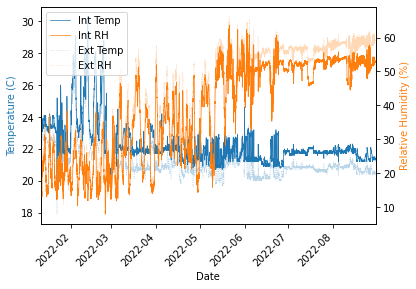

In [78]:
fig

In [60]:
type(left)

datetime.datetime

In [57]:
a = left.to_pydatetime()
type(a)

datetime.datetime

In [63]:
left = min(df.datetime) 
type(left)

pandas._libs.tslibs.timestamps.Timestamp

In [65]:
left = min(df.datetime).date()
type(left)

datetime.date

In [ ]:


# x-axis slider
x = df.datetime

#max_x = max(df.datetime)

slider = widgets.FloatSlider(description='x-axis slider', 
                             value=0, min=min(x), max=max(x), step=50, 
                             continuous_update = False,
                             orientation='vertical')
slider.style.handle_color = 'lightblue'
#display(slider)

def on_value_change(change):
    #global y
    #print(change['new'])
    #offset = change['new']
    #max_x = (max(map(max,x))) # Get max value in y_dat  
    #max_y = (max(map(max,y_dat))) # Get max value in y_dat  
    plot_update(fig, left, right) 
    #return offset, max_y

slider.observe(on_value_change, names='value')




############ UPDATE PLOT #############
def plot_update(fig, left, right):
    fig.data = [] # clear figure
    fig = plot_hygrom_combo(fig, left, right)
    fig.update_traces()
    #max_y = (max(map(max,y_dat))) # Get max value in y_dat
    #slider.max = max_y
    #slider.step = 0.05*max_y




In [ ]:
#%%
# visualize in Jupyter notebook
# Slider widgets to change x and y axis




# save data to json (?)
    #check if json file exists
        # check for new data
        # add new data and save
    #else
        # create json file and save

# Plot for each lab



# %%

# %%


In [ ]:
test = 1+1
print(test)
'''

# USE FILENAME to add on to single dataframe rather than make higher dimensional df? 



# Add smoothing option? 

### LOOP VERSION ####
for i in range (0, len(file_names)):
    #d = df[0]
    df = (pd.read_csv(file_names[i], skiprows=7, sep='\s*,', engine = 'python', skipinitialspace=True, skipfooter=1, names=['rh1','temp1','rh2','temp2','time','date']))
    #leading spaces after first row of data cause import issues. Skipping header + initial row of data appears to have fixed this issue. 
    # final row is just four spaces/ indent --> deleted with skipfooter=1

    #df.info()
    # First RH imported with '+' - need to remove
    df = df.replace({'\x00':'','\+':'','----':'0'},regex=True) # delete leading null and +

     # convert to float
    df.rh1 = pd.to_numeric(df.rh1)
    df.rh2 = pd.to_numeric(df.rh2) 
    df.temp1 = pd.to_numeric(df.temp1)
    df.temp2 = pd.to_numeric(df.temp2)

    # Create new dataframe column with datetime format
    df.loc[:,'datetime']= np.transpose([df.date + ' '+ df.time]) # combine date and time
    df.datetime = pd.to_datetime(df.datetime) # convert to datetime format (NOTE: seems slow)
    
    # delete 2012 data 
    # hygrometer defaults to year 2012 before date is set, removing this data since it is not useful
    datecut = datetime.datetime.strptime('01-01-2013 00:00:00','%m-%d-%Y %H:%M:%S')
    df = df.drop(df[df.datetime < datecut].index) # drop data where dates are in 2012

    #plot_hygrom(df)
    plot_hygrom_combo(df)
    #plot_hygrom_combo(df, left='2022-04-01', right='2022-04-30')


'''

***
Questions/Issues/Bugs? Please [contact me](mailto:kevin.deboyace@pfizer.com?subject=hygrometer_plots)
    
**Last Updated: Feb 2023**